<a href="https://colab.research.google.com/github/emilyhunter630/labs/blob/main/PCA_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question 1

In [3]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt


#df = pd.read_csv('Phishing_Email.csv')
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


**Clean the Data**

--Remove "stop words" (common words like "and," "the"), numbers, punctuation

--Convert text to lowercase and simplify words (e.g., "running" → "run")

**Create Features**

--Turn each unique word (token) into a feature using one-hot encoding (marking words as present or not)

--Alternatively, use TF-IDF to give more importance to rare but relevant words


**Reduce Dimensions**

--Use PCA to shrink the dataset into fewer features while keeping the key patterns, as text data can have too many dimensions

**Train a Model**

--Split the data into training and testing sets
--Train a model (e.g., Logistic Regression or another classifier) to predict phishing emails based on the token features

**Test and Improve**

--Check the model’s accuracy, adjust how tokens are processed, and tweak the features or model to improve predictions

Question 2

<Axes: >

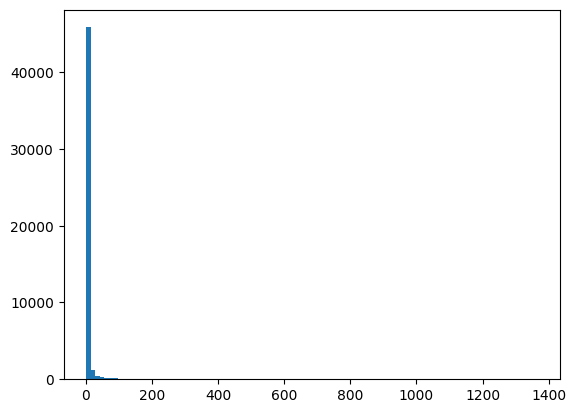

In [7]:
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

In [4]:
gdf['count'].describe()

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


Low Occurrence: The majority of tokens appear only once or twice (median and 75th percentile are 1 and 2, respectively). These rare tokens are unlikely to be useful for prediction because they don’t provide enough consistent patterns.

High Occurrence: A few tokens, like the maximum frequency token appearing 1,365 times, dominate. These are likely common words (e.g., "the" or "and") and might not contribute meaningfully to distinguishing phishing emails from safe ones.

Challenges:
Rare tokens can add clutter to the model without improving accuracy.
Overly common tokens fail to differentiate between classes.
Balancing these requires removing stop words and carefully selecting features that are both frequent enough to be useful and specific enough to provide predictive value.

Question 3

In [12]:
df = pd.read_parquet('Phishing_clean.parquet')

# The rest of your code remains the same
y = df['Email Type']
X = df.drop('Email Type',axis=1)

## 1.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=125)

## 2.
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train: ', r2_score(y_hat_train_0,y_train) )
print('test: ', r2_score(y_hat_test_0,y_test) )

train:  0.6210107280960204
test:  -0.00026838432670373


In [13]:
rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


The R^2=0.62, which is pretty good performance on the training set, but the model does not do well on the test data (-0.00027), showing it overfits due to too many features (2,611 tokens) and high correlation between them. The largest coefficients are mostly numbers (e.g., "1999," "2004"), which aren’t useful for predicting phishing emails. This highlights the need for techniques like PCA to simplify the data, reduce noise, and improve the model’s ability to generalize.

Question 4

<Axes: >

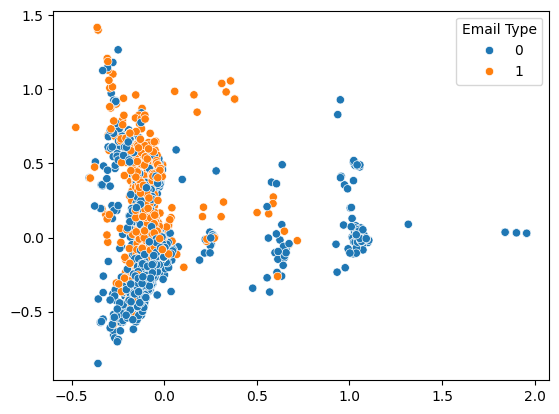

In [14]:
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

The orange dots are the phishing email points, which typically have a high value on the second component and a low value on the first component. The goal of our model is to effectively distinguish the orange dots from the blue dots.

Question 5

In [15]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('Train r2: ', r2_score(y_hat_train,y_train) )
print('Test r2: ', r2_score(y_hat_test,y_test) )

Train r2:  0.692897536096375
Test r2:  0.5873905973217184


The PCA-based regression significantly outperforms the standard linear regression, achieving an R^2 of 0.69 on the training set and 0.59 on the test set. This is a clear improvement compared to the simple linear model, which overfit the training data but performed poorly on the test set (essentially R^2=0).The PCA approach reduces overfitting by limiting the features to 2,610 principal components, making it more effective at generalizing to new data.

Question 6

Using principal components helps because they are independent and avoid problems with overlapping (multi-collinearity) in the original data. It also simplifies choosing how many features to use. However, the downside is that principal components are hard to interpret, unlike the original features (like words), which have clear meanings.

This code was created with the help of Google, Chatgbt, and Youtube tutorials!